# setup 

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices() 

[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 165405857095833288]

In [3]:
import numpy as np
import pandas as pd

from scipy import ndimage
from scipy import misc

import os, gc, sys, glob
from tqdm import tqdm

from sklearn import model_selection
from sklearn import metrics

import keras
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers.normalization import BatchNormalization
from keras.metrics import categorical_accuracy
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Input, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D

from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [18]:
DATA_DIR = os.path.join('/scratch', 'yns207', 'data_invasive')

path = DATA_DIR
test_path = os.path.join(path, 'test')
models_path = os.path.join(path, 'results')
train_path = os.path.join(path, 'train')
valid_path = os.path.join(path, 'valid')
model_name = 'model_jun23_kfold'
print(path)

/scratch/yns207/data_invasive


```
%cd $DATA_DIR
!module load centos/7
!7za x '*.7z'
```

# defining funcs

In [5]:
def conv_block(filter_depth, filter_size, pool_size, activation, inputs):
    x = BatchNormalization()(inputs)
    x = Convolution2D(filter_depth, filter_size, activation=activation)(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    return x

In [6]:
def dense_block(units, activation, drop_prob, inputs):
    x = BatchNormalization()(inputs)
    x = Dense(units, activation=activation)(x)
    x = Dropout(drop_prob)(x)
    return x

In [7]:
def output_block(units, activation, inputs):
    x = BatchNormalization()(inputs)
    x = Dense(units, activation=activation)(x)
    return x

In [8]:
def grab_optimizer(opt, lr):
    if opt == 'sgd':
        return optimizers.SGD(lr=lr, decay=1e-6, momentum=0.8, nesterov=True)
    elif opt == 'adam':
        return optimizers.Adam(lr=lr)
    elif opt == 'adagrad':
        return optimizers.Adagrad(lr=lr)
    elif opt == 'rmsprop':
        return optimizers.RMSprop(lr=lr)

In [9]:
def make_model(input_shape, optimizer):
    inputs = Input(shape=input_shape)
    m = conv_block(16, (3,3), (2,2),'relu', inputs=inputs)
    m = conv_block(32, (3,3), (2,2), 'relu', inputs=m)
    m = conv_block(64, (3,3), (2,2), 'relu', inputs=m)
    m = conv_block(128, (3,3), (2,2), 'relu', inputs=m)
    m = conv_block(256, (3,3), (2,2), 'relu', inputs=m)
    m = Flatten()(m)
    m = dense_block(2048, 'relu', 0.25, inputs=m)
    m = dense_block(512, 'relu', 0.5, inputs=m)
    outputs = dense_block(1, 'sigmoid', 0, inputs=m)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [9]:
def make_preds(model, test_data):
    # worth leaving a note:
    # prediction 1,2,3 from jun21 had misalgined the test names
    # also submission file 3 and 4 for jun21 are actually both rubmission 4 (accident)
    preds = model.predict(test_data).flatten()
    subm = test_set.copy()
    subm['invasive'] = preds
    return subm

In [10]:
train_set = pd.read_csv(os.path.join(path, 'train_labels.csv'))
test_set = pd.read_csv(os.path.join(path, 'sample_submission.csv'))

In [11]:
train_set.head(2)

,name,invasive
0,1,0
1,2,0


In [12]:
#img_shape should eb tuple
#(H,W), height, width
def read_img(img_path, img_shape):
    img = misc.imread(img_path)
    img = misc.imresize(img, img_shape)
    return img

In [13]:
def read_imgs(img_height, img_width):
    train_img, test_img = [],[]
    for img_path in tqdm(train_set['name'].iloc[:]):
        train_img.append(read_img(os.path.join(path, 'train', str(img_path)+'.jpg'), (img_height, img_width)))

    for img_path in tqdm(test_set['name'].iloc[:]):
        test_img.append(read_img(os.path.join(path, 'test', str(img_path)+'.jpg'), (img_height, img_width)))

    train_img = np.array(train_img, np.float32)/255
    test_img = np.array(test_img, np.float32)/255
    train_label = np.array(train_set['invasive'].iloc[:])
    
    return train_img, test_img, train_label

In [19]:
train_img, test_img, train_label = read_imgs(300,400)

100%|██████████| 1531/1531 [00:52<00:00, 29.21it/s]


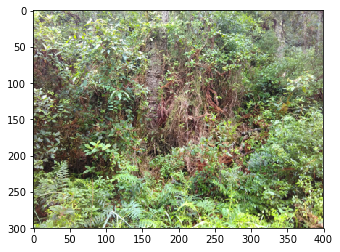

In [20]:
import matplotlib.pyplot as plt
plt.imshow(misc.imresize(train_img[50], (300,400)))
plt.show()

In [32]:
%cd $DATA_DIR
def train_model_k_folds(model, train_data, train_label, model_out,  model_init_weights, epochs, kfolds):
    kf = model_selection.KFold(n_splits=kfolds, shuffle=True)
    score_func = metrics.roc_auc_score

    i = 0
    models_stats = {}
    for train_ixs, valid_ixs in kf.split(train_data):
        x_train = train_data[train_ixs]
        x_valid = train_data[valid_ixs]
        y_train = train_label[train_ixs]
        y_valid = train_label[valid_ixs]

        gen = ImageDataGenerator(
            rotation_range = 30,
            width_shift_range = 0.2,
            height_shift_range = 0.2,
            shear_range = 0.2,
            zoom_range = 0.2,
            horizontal_flip = True,
            vertical_flip = True,
            fill_mode = 'nearest')
        
        #re-initialzie the weights of the model on each run
        model.load_weights(model_init_weights)
        model_out_file = '/scratch/yns207/data_invasive/{}_{}.model'.format(model_out, str(i))
        model_checkpoint = ModelCheckpoint(model_out_file, 
                                            monitor='val_loss', 
                                            save_best_only=True)
        early_stopping = EarlyStopping(monitor='val_loss', patience=25, verbose=1, mode='auto')

        hist = model.fit_generator(gen.flow(x_train, y_train, batch_size=64),
                            steps_per_epoch=(len(x_train)//64) + 1,
                            validation_data=(x_valid,y_valid),
                            validation_steps=(len(x_valid)//64)+1,
                            epochs=epochs,
                            verbose=1,
                            callbacks=[early_stopping, model_checkpoint])
        
        model.load_weights(model_out_file)
        
        eval_tr = model.evaluate(x_train, y_train)
        eval_va = model.evaluate(x_valid, y_valid)
        
        tr_score = score_func(y_train, model.predict(x_train)[:, 0])
        va_score = score_func(y_valid, model.predict(x_valid)[:, 0])
        
        print('\n')
        print('kfold: {}'.format(str(i)))
        print('best model train acc: {}, loss: {}'.format(eval_tr[1], eval_tr[0]))
        print('best model valid acc: {}, loss: {}'.format(eval_va[1], eval_va[0]))
        print('best model train aroc score: {}, valid aroc score: {}'.format(tr_score, va_score))
        print('\n')
        models_stats[model_out_file] = {'score_tr_va':[tr_score, va_score], 'train_acc_loss':[eval_tr[1], eval_tr[0]], 'val_acc_loss':[eval_va[1], eval_va[0]]}
        i += 1
        
    return models_stats

/scratch/yns207/data_invasive


In [1]:
make_model((300,400,3), grab_optimizer('adam', 0.000125)).summary()

NameError: name 'make_model' is not defined

In [ ]:
# make a model
model = make_model((300,400,3), grab_optimizer('adam', 0.000125))
# save initial weights for use on each kfolds run
model.save_weights('{}_base.model'.format(model_name))
# run kfolds 10x
models_stats = train_model_k_folds(model, train_img, train_label, model_name, '{}_base.model'.format(model_name), 100, 10)

Epoch 1/100
33/33 [==============================] - 37s - loss: 0.6629 - acc: 0.6994 - val_loss: 1.4198 - val_acc: 0.3783
Epoch 2/100
33/33 [==============================] - 34s - loss: 0.5587 - acc: 0.7684 - val_loss: 2.4889 - val_acc: 0.3783
Epoch 3/100
33/33 [==============================] - 35s - loss: 0.4886 - acc: 0.7784 - val_loss: 1.5785 - val_acc: 0.3783
Epoch 4/100
33/33 [==============================] - 34s - loss: 0.4707 - acc: 0.7986 - val_loss: 3.4170 - val_acc: 0.3783
Epoch 5/100
33/33 [==============================] - 34s - loss: 0.4134 - acc: 0.8316 - val_loss: 4.3127 - val_acc: 0.3783
Epoch 6/100
33/33 [==============================] - 34s - loss: 0.4009 - acc: 0.8390 - val_loss: 4.7340 - val_acc: 0.3783
Epoch 7/100
33/33 [==============================] - 34s - loss: 0.3925 - acc: 0.8386 - val_loss: 2.6883 - val_acc: 0.3783
Epoch 8/100
33/33 [==============================] - 34s - loss: 0.3733 - acc: 0.8539 - val_loss: 2.6066 - val_acc: 0.3783
Epoch 9/100
33/3

33/33 [==============================] - 35s - loss: 0.1691 - acc: 0.9294 - val_loss: 0.1589 - val_acc: 0.9522
Epoch 31/100
33/33 [==============================] - 34s - loss: 0.1698 - acc: 0.9329 - val_loss: 0.1945 - val_acc: 0.9217
Epoch 32/100
33/33 [==============================] - 34s - loss: 0.1669 - acc: 0.9389 - val_loss: 0.1813 - val_acc: 0.9348
Epoch 33/100
33/33 [==============================] - 34s - loss: 0.1661 - acc: 0.9376 - val_loss: 0.1640 - val_acc: 0.9565
Epoch 34/100
33/33 [==============================] - 34s - loss: 0.1820 - acc: 0.9375 - val_loss: 0.1688 - val_acc: 0.9304
Epoch 35/100
33/33 [==============================] - 35s - loss: 0.1664 - acc: 0.9406 - val_loss: 0.1500 - val_acc: 0.9435
Epoch 36/100
33/33 [==============================] - 34s - loss: 0.1552 - acc: 0.9422 - val_loss: 0.1822 - val_acc: 0.9435
Epoch 37/100
33/33 [==============================] - 34s - loss: 0.1678 - acc: 0.9420 - val_loss: 0.1980 - val_acc: 0.9391
Epoch 38/100
33/33 [=

33/33 [==============================] - 35s - loss: 0.1361 - acc: 0.9529 - val_loss: 0.1081 - val_acc: 0.9609
Epoch 60/100
33/33 [==============================] - 34s - loss: 0.1320 - acc: 0.9504 - val_loss: 0.1573 - val_acc: 0.9348
Epoch 61/100
33/33 [==============================] - 34s - loss: 0.1069 - acc: 0.9613 - val_loss: 0.1270 - val_acc: 0.9522
Epoch 62/100
33/33 [==============================] - 34s - loss: 0.1165 - acc: 0.9588 - val_loss: 0.1314 - val_acc: 0.9609
Epoch 63/100
33/33 [==============================] - 34s - loss: 0.1145 - acc: 0.9506 - val_loss: 0.1240 - val_acc: 0.9565
Epoch 64/100
33/33 [==============================] - 34s - loss: 0.1316 - acc: 0.9540 - val_loss: 0.1155 - val_acc: 0.9391
Epoch 65/100
33/33 [==============================] - 34s - loss: 0.1220 - acc: 0.9526 - val_loss: 0.1103 - val_acc: 0.9565
Epoch 66/100
33/33 [==============================] - 35s - loss: 0.1092 - acc: 0.9632 - val_loss: 0.1032 - val_acc: 0.9565
Epoch 67/100
33/33 [=

33/33 [==============================] - 34s - loss: 0.1038 - acc: 0.9586 - val_loss: 0.0552 - val_acc: 0.9870
Epoch 89/100
33/33 [==============================] - 34s - loss: 0.0884 - acc: 0.9684 - val_loss: 0.0803 - val_acc: 0.9826
Epoch 90/100
33/33 [==============================] - 34s - loss: 0.0929 - acc: 0.9681 - val_loss: 0.0587 - val_acc: 0.9739
Epoch 91/100
33/33 [==============================] - 34s - loss: 0.0984 - acc: 0.9621 - val_loss: 0.0636 - val_acc: 0.9696
Epoch 92/100
33/33 [==============================] - 34s - loss: 0.0915 - acc: 0.9664 - val_loss: 0.0604 - val_acc: 0.9783
Epoch 93/100
33/33 [==============================] - 34s - loss: 0.0897 - acc: 0.9665 - val_loss: 0.0974 - val_acc: 0.9739
Epoch 94/100
33/33 [==============================] - 34s - loss: 0.0781 - acc: 0.9668 - val_loss: 0.0524 - val_acc: 0.9826
Epoch 95/100
33/33 [==============================] - 34s - loss: 0.0952 - acc: 0.9656 - val_loss: 0.0736 - val_acc: 0.9739
Epoch 96/100
33/33 [=

In [35]:
models_stats

{'/scratch/yns207/data_invasive/model_jun23_kfold_0.model': {'score_tr_va': [0.9989806412583182,
   0.99533799533799527],
  'train_acc_loss': [0.98740920096852303, 0.047803015121400859],
  'val_acc_loss': [0.95217391304347831, 0.091406089844910998]},
 '/scratch/yns207/data_invasive/model_jun23_kfold_1.model': {'score_tr_va': [0.99964427658150801,
   0.99160206718346244],
  'train_acc_loss': [0.9922518159806295, 0.034331732959493308],
  'val_acc_loss': [0.96086956521739131, 0.10831465586898444]},
 '/scratch/yns207/data_invasive/model_jun23_kfold_2.model': {'score_tr_va': [0.99886179551505017,
   0.99587301587301591],
  'train_acc_loss': [0.9869249394673123, 0.045531589930232153],
  'val_acc_loss': [0.97826086956521741, 0.078597404783510641]},
 '/scratch/yns207/data_invasive/model_jun23_kfold_3.model': {'score_tr_va': [0.99946763951360329,
   0.99924999999999997],
  'train_acc_loss': [0.9869249394673123, 0.031575887154147352],
  'val_acc_loss': [0.97826087060181988, 0.039775796040244726]

In [ ]:
# ok so this time around well just pick 3:

# /scratch/yns207/data_invasive/model_jun23_kfold_3.model has a REALLY good validation aroc and really solid training/validation losses
# aroc - 0.99924999999999997
# va loss 0.039775796040244726, tr loss 0.031575887154147352
# /scratch/yns207/data_invasive/model_jun23_kfold_7.model good aroc, good validation/training loss
# aroc - 0.99867303609341829
# va loss  0.044601682505436141, tr loss 0.032854350058349267
# /scratch/yns207/data_invasive/model_jun23_kfold_9.model 
# aroc 0.99881856540084391
# va loss  0.051698353906125483 tr loss 0.049622103622379746

# these seem good

In [36]:
subm = test_set.iloc[:]
subm = subm.drop('invasive',1)

%cd $DATA_DIR
models = [3,7,9]
model = make_model((300,400,3), grab_optimizer('adam', 0.000125))

for f in models:
    model.load_weights('{}_{}.model'.format(model_name, str(f)))
    subm[str(f)] = make_preds(model, test_img)['invasive']
subm.head()

/scratch/yns207/data_invasive


,name,3,7,9
0,1,0.999828,0.996884,0.998312
1,2,0.001447,0.001548,0.010434
2,3,0.014298,0.020349,0.255950
3,4,0.000775,0.000779,0.000382
4,5,0.998618,0.993972,0.924468


In [37]:
subm['invasive'] = subm[[str(f) for f in models]].mean(axis=1)
subm = subm.drop([str(f) for f in models], 1)
subm.head()

,name,invasive
0,1,0.998341
1,2,0.004476
2,3,0.096866
3,4,0.000645
4,5,0.972352


In [38]:
subm.to_csv(os.path.join(DATA_DIR, 'results', 'subm_jun_23_17_0.gz'), index=False, compression='gzip')

# summary

not sure how this model ensemble performs (but i think its gonna be good). next we could try the stuff mentioned here:

http://blog.kaggle.com/2017/04/20/dogs-vs-cats-redux-playground-competition-3rd-place-interview-marco-lugo/

https://gogul09.github.io/software/flower-recognition